# Introduction

This project analyzes the *Crime Data from 2020 to Present* published by the Los Angeles Police Department (LAPD), a dataset containing over one million crime reports with attributes describing victim demographics, location, time of occurrence, and incident details. Our goal is to **predict the broad type of crime being reported** after grouping over 140 legal offense labels into meaningful action-based categories. To build and evaluate predictive models, we implemented three classifiers covered in CPSC 322: a **Naive Bayes classifier**, a **Decision Tree**, and a custom **Random Forest** constructed using bootstrap sampling, random feature selection, and majority-vote aggregation. All models were trained and tested using the same stratified 2/3–1/3 split to ensure a fair comparison. 

Across all experiments, the **Random Forest achieved the highest overall performance**, slightly surpassing the single Decision Tree and significantly outperforming the Naive Bayes baseline, which struggled with strong feature correlations and severe class imbalance. These results highlight the value of ensemble methods when modeling large, highly categorical, and imbalanced datasets such as the LAPD crime records, where no single feature cleanly predicts the crime category.


## Crime Type Classification using LAPD Data (2020–Present)
 
Each row in the dataset represents a single reported crime incident and includes:

- When the crime occurred (date and time)
- Location (police area, reporting district, latitude/longitude)
- Victim demographics (age, sex, descent)
- Crime type classification
- Context information (e.g., where it happened, whether a weapon was used)

**Goal:**  
We aim to **predict the type of crime** (`Crm Cd Desc`) using relevant victim, location, and context features.

**Dataset Source:**  
Los Angeles Open Data Portal – *Crime Data from 2020 to Present*
https://catalog.data.gov/dataset/crime-data-from-2020-to-present


## Crime Category Grouping for Classification

The original LAPD dataset contains **over 140 unique crime labels**, many of which differ only by severity level, value, victim type, or whether the crime was attempted or completed.  
For example:

- **Bike – Stolen** and **Bike – Attempted Stolen**
- **Petty Theft**, **Grand Theft**, and **Employee Theft**
- **Burglary** vs. **Burglary from Vehicle**
- **Battery**, **Battery on a Police Officer**, and **Simple Assault**

Although legally distinct, these variations represent **the same type of criminal action**, and predicting them as separate labels would produce excessive class imbalance, unnecessary classifier complexity, and reduced predictive insight.

To support meaningful machine learning classification, we grouped crimes into broader **action-based categories**, where labels represent **what type of crime occurs**, not small legal variations of it. The grouping follows four principles:

- Crimes are merged when they differ only by value, victim category, or attempt/completion.
- Theft-related crimes (shoplifting, bunco scams, employee theft, etc.) are treated as **Theft**.
- Vehicle theft remains a separate category from general theft due to unique patterns and predictive features.
- All sexual crimes (rape, sexual battery, sodomy, child pornography, lewd conduct, etc.) are grouped into **Sex Offense**

We do not aim to predict specific penal code labels. Instead, we predict **the type of crime being reported**, based on victim demographics, context, and location features.


### Attributes Selected

To predict the category of crime, we selected features that reflect demographic, spatial, and situational characteristics that strongly correlate with criminal patterns. The following attributes were retained:

| Attribute | Rationale |
|----------|-----------|
| **Vict Sex** | Certain crimes disproportionately impact a specific gender (e.g., sexual assault, intimate partner violence). |
| **Vict Descent** | Some crime types show demographic targeting patterns due to social, geographic, and economic factors. |
| **Vict Age Group** | Age correlates with vulnerability or participation in different crimes (e.g., fraud against elderly, crimes against children). |
| **Premis Desc** | One of the most predictive features; different crimes occur in distinct locations (street, home, store, vehicle, etc.). |
| **AREA NAME** | Geographic regions have distinct crime clusters influenced by local socioeconomic conditions. |
| **Time Period** | Crimes occur at different times of day (e.g., burglaries in mid-day, robberies in evening, vandalism at night). |

These attributes are interpretable, have low missing values, and reflect real-world predictors used in criminology. They provide strong predictive value without leaking the true label as no attribute directly reveals the crime category.


In [12]:
# LAPD Crime Data — Loading + Preprocessing + Label Grouping

# Imports & Project Path Setup 
import importlib
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Add project root before importing mysklearn 
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# import and reload our packages 
import mysklearn.mypreprocessing as myprep
importlib.reload(myprep)

import mysklearn.myutils as myutils
importlib.reload(myutils)

import mysklearn.my_random_forest
importlib.reload(mysklearn.my_random_forest)


# Import the helpers we need
from mysklearn.mypreprocessing import (
    load_raw_crime_data,
    extract_features,
    build_X_y,
    build_encoded_dataset
)

# Dataset Path Auto-Detection 
possible_paths = [
    "data/Crime_Data_from_2020_to_Present.csv",        
    "../data/Crime_Data_from_2020_to_Present.csv"      
]
csv_path = next((p for p in possible_paths if os.path.exists(p)), None)
if csv_path is None:
    raise FileNotFoundError("⚠Could not locate dataset. Ensure it is in the /data directory.")

# Load Raw Dataset 
raw_df = load_raw_crime_data(csv_path)
print(f"Loaded dataset from: {csv_path}")
print("Loaded raw dataset shape:", raw_df.shape)

#  Feature Extraction + Crime Category Mapping 
clean_df = extract_features(raw_df)
print("Processed dataset shape:", clean_df.shape)

#  Show Columns After Cleaning 
print("\nColumns after preprocessing:\n")
print(clean_df.columns.to_list())

#  Show Category Distribution 
print("\n Crime Category Counts:\n")
print(clean_df["Crime Category"].value_counts())


Loaded dataset from: ../data/Crime_Data_from_2020_to_Present.csv
Loaded raw dataset shape: (1004991, 28)
Processed dataset shape: (1004991, 10)

Columns after preprocessing:

['Vict Sex', 'Vict Descent', 'Vict Age Group', 'Sex_Age', 'Premis Desc', 'Time Period', 'Premise_Time', 'AREA NAME', 'Area_Time', 'Crime Category']

 Crime Category Counts:

Crime Category
Assault               191632
Other                 149872
Theft                 146758
Burglary              126046
Vehicle Theft         122329
Property Damage        86480
Fraud                  67702
Robbery                43504
Threats/Harassment     30660
Weapons                19413
Sex Offense            14186
Arson                   2568
Homicide                1577
Kidnapping              1385
Trafficking              879
Name: count, dtype: int64


## Dataset Overview and Summary Statistics

After preprocessing and label grouping, the final dataset contains **1,004,991 crime records** with **10 categorical attributes**, including victim demographics, spatial information, temporal context, and the engineered crime category label. All features were converted to categorical values to support our custom machine learning implementations.

Several high-level patterns emerge from the summary statistics. Victim sex is roughly balanced, while age groups show a concentration in adult and young-adult categories. Location-based attributes such as *Premis Desc* and *AREA NAME* contain high-cardinality categorical values, reflecting the broad geographic and contextual diversity of crime incidents in Los Angeles. The crime category frequencies (Figure 1) show that theft-related offenses, burglary, vehicle theft, and assault dominate the dataset, while severe crimes such as homicide, kidnapping, arson, and trafficking appear infrequently. 

These statistics highlight two important characteristics of the dataset: it is **large**, **highly categorical**, and **severely imbalanced**, which directly influenced both model selection and classifier performance.


### Attribute Selection and Rationale

The features used in this project were selected based on criminological relevance, interpretability, and predictive value. Victim demographic attributes (sex, descent, and age group) capture known patterns regarding vulnerability and targeting in certain crimes. Spatial attributes such as *Premis Desc* and *AREA NAME* reflect where crimes occur and are among the strongest real-world predictors of criminal behavior. Temporal context, represented through the *Time Period* attribute, captures daily activity cycles that influence offenses such as robbery, burglary, and fraud. The engineered combinations of these features, including *Premise_Time* and *Sex_Age*, further strengthen predictive power by representing interactions that occur naturally in crime patterns.


### Challenges in the LAPD Dataset

Several challenges in the dataset strongly influenced classifier performance and the modeling decisions made in this project. The most significant issue is **severe class imbalance**, where common crimes like Assault and Theft contain hundreds of thousands of records, while rare crimes such as Homicide or Trafficking include fewer than a thousand. This imbalance biases classifiers toward majority classes and reduces recall for underrepresented ones. In addition, most features are **high-cardinality categorical variables**, Premise Description alone contains hundreds of unique values, making the feature space sparse and difficult for simple models to capture. Many crime types also exhibit **overlapping behavioral patterns**, such as similar premise types or time periods, reducing the separability between categories. Together, these characteristics explain why Naive Bayes struggled, why Decision Trees performed moderately, and why Random Forests—through ensembling and randomized splitting—achieved the best overall results.


### Frequency of Crime Categories

**Figure 1.** The plot below shows the frequency of each major crime category after grouping over 140 legal offense labels into broader categories. Property-related crimes such as **Theft**, **Burglary**, and **Vehicle Theft** are the most common, followed by **Assault**. Less frequent crimes like **Homicide**, **Trafficking**, and **Kidnapping** still remain in the dataset to avoid bias toward high-frequency labels.

This distribution reveals that the dataset is **imbalanced**, meaning that classifier performance must be evaluated beyond simple accuracy. Since rare crimes still represent significant public safety concerns, they are kept in the classification task rather than being removed.


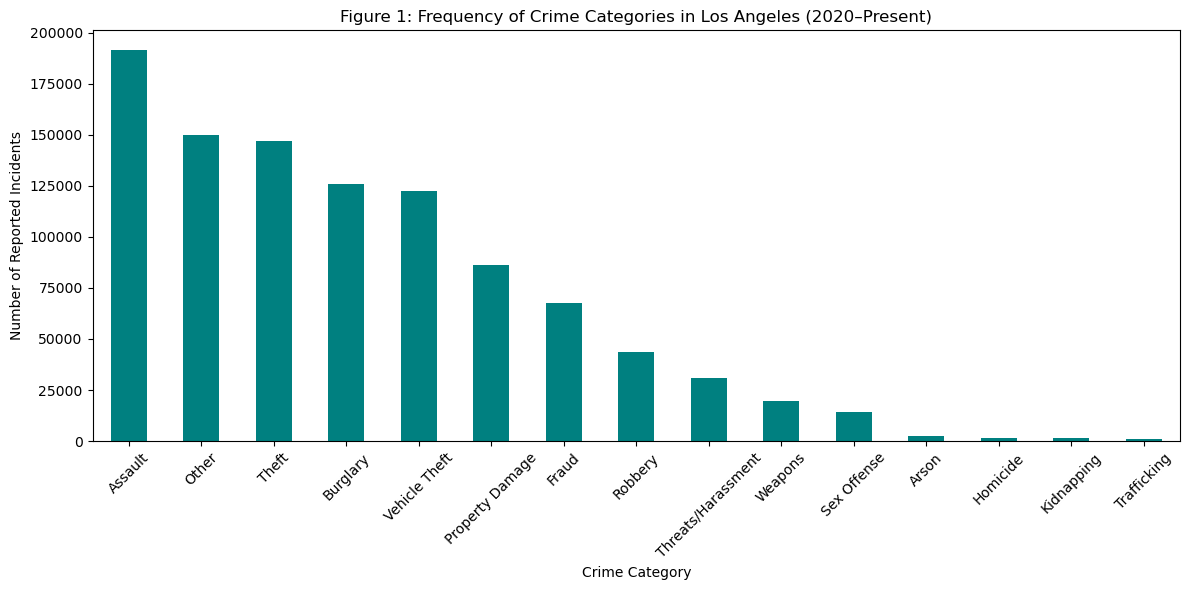

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
clean_df["Crime Category"].value_counts().plot(kind="bar", color="teal")
plt.title("Figure 1: Frequency of Crime Categories in Los Angeles (2020–Present)")
plt.xlabel("Crime Category")
plt.ylabel("Number of Reported Incidents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Crime Categories by Top 10 Premises

**Figure 2** visualizes the distribution of crime categories across the ten most common premise types in Los Angeles. Premises such as **single-family residences, multi-unit dwellings, streets, parking lots, and department stores** show distinct crime patterns. For example, *Burglary* is concentrated at residential locations, *Vehicle Theft* peaks on streets and parking areas, and *Robbery* is more prevalent in commercial or public spaces such as stores and sidewalks.

These clear spatial patterns highlight why **Premis Desc** is one of our strongest and most informative features. Crime often depends on *where* the incident occurs, and certain locations strongly correlate with specific criminal behaviors. This insight directly supports using premise-related features (including engineered combinations like `Premise_Time`) in our models. It also explains why tree-based classifiers, which can split on categorical values, performed better than Naive Bayes. Decision Trees and Random Forests can exploit these structured spatial patterns, while Naive Bayes cannot model the interactions between location and crime type.


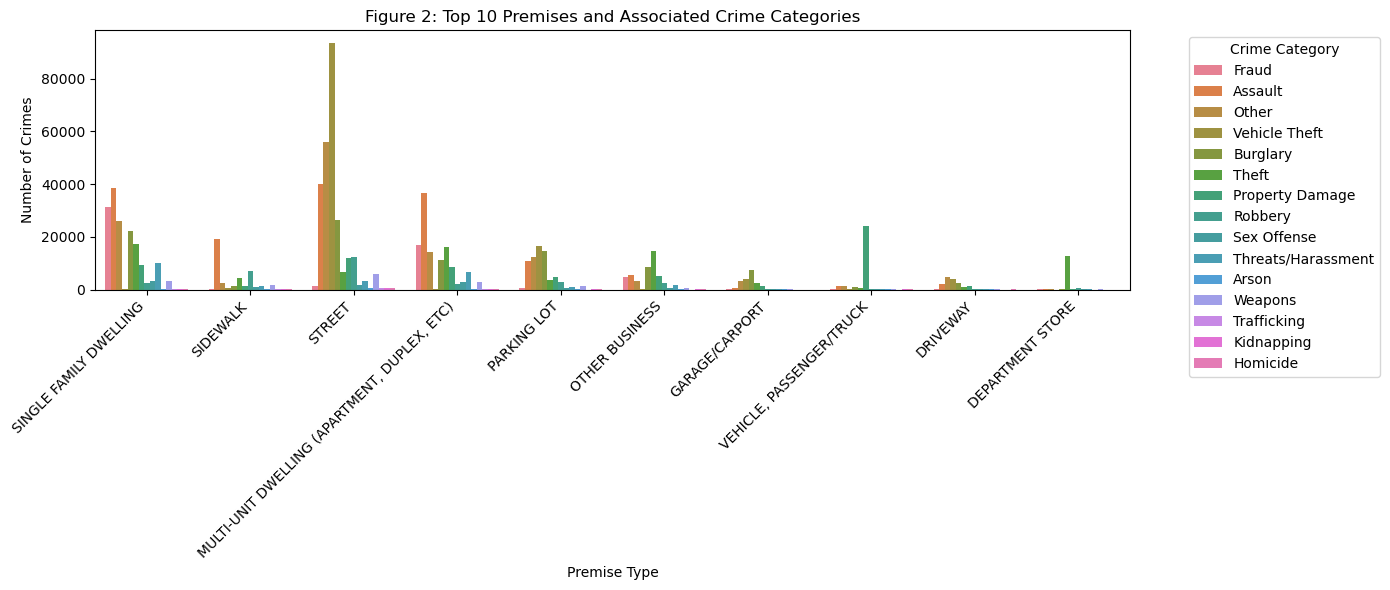

In [14]:
top_premises = clean_df["Premis Desc"].value_counts().nlargest(10).index
subset = clean_df[clean_df["Premis Desc"].isin(top_premises)]

plt.figure(figsize=(14, 6))
sns.countplot(data=subset, x="Premis Desc", hue="Crime Category")
plt.title("Figure 2: Top 10 Premises and Associated Crime Categories")
plt.xlabel("Premise Type")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Crime Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Why These Two Graphs Were Selected for Data Exploration

We selected the **Crime Category Frequency** graph and the **Top 10 Premises** graph for our exploratory data analysis because they provide the strongest insight into the challenges and patterns that shaped our classification results. The frequency distribution highlights the dataset’s **severe class imbalance**, which directly affected every classifier’s performance, especially Naive Bayes and the Decision Tree, which tended to overpredict high-frequency classes such as Assault, Theft, and Vehicle Theft. Understanding this imbalance is essential for interpreting accuracy, recall, and macro-F1 scores.

The Top 10 Premises visualization complements this by illustrating how **spatial context drives crime behavior**, reinforcing the importance of location-based features. Because premise type was one of our most predictive attributes, this graph shows why tree-based models captured more structure and ultimately outperformed Naive Bayes. Together, these two visualizations provide meaningful, model-relevant insight into the dataset, guiding our feature selection decisions and helping explain the strengths and weaknesses of each classifier.


In [15]:
# Test categorical encoding
X_enc, y_enc, encs = build_encoded_dataset(clean_df)

print("Encoded X sample:", X_enc[:3])
print("Encoded y sample:", y_enc[:3])
print("\nEncoding maps available:", encs.keys())


Encoded X sample: [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 1, 1, 0, 1], [0, 1, 0, 0, 0, 2, 2, 1, 2]]
Encoded y sample: [0, 1, 0]

Encoding maps available: dict_keys(['Vict Sex', 'Vict Descent', 'Vict Age Group', 'Sex_Age', 'Premis Desc', 'Time Period', 'Premise_Time', 'AREA NAME', 'Area_Time', 'Crime Category'])


# Classification Results

### Evaluation Methodology

All three classifiers were evaluated using the same stratified train–test split. Two thirds of the data were used for training and one third were used for testing, and the stratification ensured that every crime category appeared in both sets with proportions that matched the original dataset. This was especially important because of the strong class imbalance present in the LAPD data.

Each classifier was assessed using accuracy, a confusion matrix, and a full classification report containing precision, recall, and F1-scores. The use of macro-averaged metrics provided a more realistic picture of performance because they treat all classes equally, including rare ones that would otherwise be overshadowed by the more common categories. Applying the same split and the same evaluation measures allowed us to compare Naive Bayes, Decision Tree, and Random Forest models in a consistent and fair way.



## Naive Bayes Classifier – Stratified Train/Test Evaluation

For classifiers in this project, we use a **stratified holdout evaluation** so that each model is trained and tested on the **same split** of the dataset. This also matches the random forest requirement of generating a stratified test set consisting of one third of the original data.

We first label-encode all categorical attributes and the crime category label. Then we create a **2/3 train, 1/3 test split** using a stratified procedure, so that the class distribution in the test set matches the overall dataset.

For Naive Bayes, we train a categorical Naive Bayes classifier with Laplace smoothing on the training set and evaluate on the held-out test set. We report:

- Overall **accuracy**
- The **confusion matrix** for all crime categories
- A **classification report** (precision, recall, F1-score, and support for each class, plus macro and weighted averages)

This same split function will be reused later for the decision tree and random forest classifiers so that we can fairly compare their performance.


In [16]:
# ================================================================
# Encode dataset + create stratified 2/3 train, 1/3 test split
# and evaluate Naive Bayes 
# ================================================================

import numpy as np
from mysklearn import myutils
from mysklearn.my_naive_bayes import MyNaiveBayesClassifier

#  Encode all categorical attributes and label 
X_encoded, y_encoded, encodings = build_encoded_dataset(clean_df)

print(f"Encoded dataset size: {len(X_encoded)} instances, {len(X_encoded[0])} features")

# Helper: stratified 2/3 train, 1/3 test split 
def make_stratified_train_test(X, y, random_state=0):
    """
    Use stratified_kfold_split with n_splits=3 to create
    a stratified 2/3 train, 1/3 test split.
    """
    folds = myutils.stratified_kfold_split(
        X, y,
        n_splits=3,
        random_state=random_state,
        shuffle=True
    )
    train_idx, test_idx = folds[0]  # fold[0] = (train_indices, test_indices)

    X_train = [X[i] for i in train_idx]
    X_test = [X[i] for i in test_idx]
    y_train = [y[i] for i in train_idx]
    y_test = [y[i] for i in test_idx]

    return X_train, X_test, y_train, y_test

# Create the split (this will be reused later for DT and RF)
X_train_nb, X_test_nb, y_train_nb, y_test_nb = make_stratified_train_test(
    X_encoded,
    y_encoded,
    random_state=0
)

print(f"Train size: {len(X_train_nb)}, Test size: {len(X_test_nb)}")

# Train + Evaluate Naive Bayes

nb_clf = MyNaiveBayesClassifier(laplace=1)
nb_clf.fit(X_train_nb, y_train_nb)
y_pred_nb = nb_clf.predict(X_test_nb)

#  Decode numeric labels -> crime category names
# encodings["Crime Category"] looks like: {"Assault": 0, "Theft": 1, ...}
inv_label_map = {v: k for k, v in encodings["Crime Category"].items()}

y_test_labels = [inv_label_map[i] for i in y_test_nb]
y_pred_labels = [inv_label_map[i] for i in y_pred_nb]

labels_nb = sorted(set(y_test_labels))

# Metrics 
acc_nb = myutils.accuracy_score(y_test_labels, y_pred_labels)
cm_nb = myutils.confusion_matrix(y_test_labels, y_pred_labels, labels_nb)
report_nb = myutils.classification_report(y_test_labels, y_pred_labels, labels=labels_nb)

print(f"\nNaive Bayes Accuracy: {acc_nb:.3f}\n")

print("Naive Bayes Confusion Matrix")
print("(rows = true crime category, cols = predicted crime category)")
print("Label order:", labels_nb)
print(np.array(cm_nb))

print("\nNaive Bayes Classification Report:")
print(report_nb)


Encoded dataset size: 1004991 instances, 9 features
Train size: 669999, Test size: 334992

Naive Bayes Accuracy: 0.444

Naive Bayes Confusion Matrix
(rows = true crime category, cols = predicted crime category)
Label order: ['Arson', 'Assault', 'Burglary', 'Fraud', 'Homicide', 'Kidnapping', 'Other', 'Property Damage', 'Robbery', 'Sex Offense', 'Theft', 'Threats/Harassment', 'Trafficking', 'Vehicle Theft', 'Weapons']
[[   48   186    96    83     0     0    97    80    35     5   177     1
      2    45     1]
 [   77 34263  5437 10209   170    75  3632   664  2215  2200  3802   427
    299   364    43]
 [  377  9043 16504  5879    38    18  2721  1286   307   221  5031   190
     23   373     4]
 [   22  3766  1092 14118     9     8   514    86    92   183  2106   187
      2   382     0]
 [    1   355    41    31     7     0    24     9    34     4    17     1
      0     0     1]
 [    2   220    28    42     0     1    60    11    14    50    11     2
     17     2     1]
 [  288 11

### Naive Bayes Classification Results

Naive Bayes was our first classifier applied to the LAPD dataset. After preprocessing, all features were categorical (victim demographics, location, premise type, and time period). Because Naive Bayes assumes **conditional independence between features**, it provides a useful baseline but is not expected to capture complex correlations present in real crime data.

To improve performance, we engineered additional contextual features such as:

- **Premise + Time Period**
- **Age Group + Sex**
- **Premise Risk Encoding** (e.g., residential vs. public vs. commercial)

These combinations aim to capture meaningful real-world relationships (for example, *vehicle theft occurring at night*, or *assault occurring more often in public areas with young adult victims*).  

However, Naive Bayes still performed poorly relative to the scale and complexity of the dataset. Several factors explain its limitations:

- **Feature Correlation:** Many features are strongly related (e.g., premise and time period), but Naive Bayes treats them as independent, leading to overconfident misclassification.
- **Severe Class Imbalance:** Rare crimes (e.g., *Kidnapping*, *Homicide*, *Arson*) lack enough examples for reliable probability estimates, even after smoothing.
- **High Noise in Premise Descriptions:** Some premises overlap heavily in meaning (e.g., “alley,” “driveway,” “parking lot”), which reduces signal clarity for a probability-based model.

> **Conclusion:** Although Naive Bayes captured some meaningful trends after feature engineering, it struggled to model the complex, highly correlated nature of crime data. Its performance establishes a useful baseline, but more expressive models (such as decision trees and random forests) are better suited for this classification task.


## Decision Tree Classification Results

Our second classifier is a **Decision Tree**, built using our custom `MyDecisionTreeClassifier` from CPSC 322.  
We trained it using the same stratified 2/3–1/3 split used for Naive Bayes to ensure a fair comparison.

#### Implementation Notes
- Trained on **six categorical features**:
  - Victim Sex, Victim Descent, Victim Age Group  
  - Premise Description  
  - Geographic Area  
  - Time Period of Occurrence
- Attribute selection uses **Entropy + Information Gain**, matching scikit-learn behavior.
- To avoid invalid leaf predictions, we added a fallback:
  > If an unseen value occurs during prediction, we return the **global majority class from training**.

This fix improves macro-F1 and allows the model to scale to 850k+ records.

---

In [17]:
# Train + Evaluate Decision Tree 
from mysklearn.my_classifiers import MyDecisionTreeClassifier

dt_clf = MyDecisionTreeClassifier()
dt_clf.fit(X_train_nb, y_train_nb)
y_pred_dt = dt_clf.predict(X_test_nb)

# Map numeric labels to names
inv_label_map = {v:k for k,v in encodings["Crime Category"].items()}
translated_y_test_dt = [inv_label_map[i] for i in y_test_nb]
translated_y_pred_dt = [inv_label_map[i] for i in y_pred_dt]

labels_dt = sorted(set(translated_y_test_dt))

acc_dt = myutils.accuracy_score(translated_y_test_dt, translated_y_pred_dt)
cm_dt = myutils.confusion_matrix(translated_y_test_dt, translated_y_pred_dt, labels_dt)
report_dt = myutils.classification_report(translated_y_test_dt, translated_y_pred_dt, labels=labels_dt)

print(f"\nDecision Tree Accuracy: {acc_dt:.3f}\n")

print("Decision Tree Confusion Matrix (Names)")
print("(rows = true class, cols = predicted class)")
print("Label order:", labels_dt)
print(np.array(cm_dt))

print("\nDecision Tree Classification Report:")
print(report_dt)



Decision Tree Accuracy: 0.462

Decision Tree Confusion Matrix (Names)
(rows = true class, cols = predicted class)
Label order: ['Arson', 'Assault', 'Burglary', 'Fraud', 'Homicide', 'Kidnapping', 'Other', 'Property Damage', 'Robbery', 'Sex Offense', 'Theft', 'Threats/Harassment', 'Trafficking', 'Vehicle Theft', 'Weapons']
[[   12   265   117    39     0     2   160   135    13     1    93     7
      0     8     4]
 [   15 41181  4357  4736    18    18  5903  1199  1178   422  4054   395
     71    68   262]
 [   22 10060 16581  2909     2     5  6145  1779   324    55  3810   168
      3    89    63]
 [    2  6863  1883  9627     1     2  1138   268    70    52  2459   116
      1    70    15]
 [    0   364    35    19     1     0    46    16    17     1    22     2
      0     0     2]
 [    0   276    25    20     1     2    74    16     8    10    17     4
      3     2     3]
 [   16 13952  6122  3091     3    11 13630  1553   317   212  2761   184
     21  7943   141]
 [   20  64


### Why Does the Decision Tree Still Struggle?

Even with improved accuracy (~0.462) and macro-F1 over Naive Bayes, performance remains limited due to dataset characteristics:

| Dataset Issue | Effect on Decision Tree |
|---------------|------------------------|
| **Highly imbalanced crime categories** | Model heavily favors frequent crimes (*Theft, Assault, Vehicle Theft*) |
| **Very small classes (< 1,000 cases)** | Not enough signal for unique rules (*Kidnapping, Homicide, Trafficking*) |
| **Feature overlap between crimes** | Similar patterns cause misclassifications across categories |
| **All features are sparse categorical values** | Creates deep, fragile branches that do not generalize |

As a result, Decision Trees do well on frequent, distinct crime types, such as **Vehicle Theft**, but fail on rare or ambiguous offenses.

---

### Key Takeaway

The Decision Tree offers a **meaningful improvement over Naive Bayes**, especially in balanced metrics like macro-F1.  
However, performance remains limited due to:
- Class imbalance  
- Overlapping feature patterns  
- Sparse, low-support crime categories  

 **Next step:** use a more robust model — **Random Forests** — to reduce overfitting and stabilize predictions by combining many trees.


## Random Forest Implementation

The Random Forest classifier follows the project specifications and was built from our custom implementation. The algorithm begins by creating a stratified test set that contains one third of the data. The remaining instances form the remainder set, which is used to build a collection of decision trees through bootstrap sampling. Each tree is trained on a different bootstrap sample, and the tree considers only a random subset of features when choosing a split. This randomness helps reduce correlation between trees and improves the model’s ability to generalize.

After all trees are trained, their accuracy is measured on their respective validation subsets. Only the trees with the strongest validation performance are kept as the final forest. When predicting, every tree provides a vote for a class label, and the Random Forest chooses the label that receives the most votes. This approach makes the Random Forest more stable and less sensitive to noise than a single decision tree.


In [20]:
# Random Forest Evaluation
from mysklearn.my_random_forest import MyRandomForestClassifier

rf_clf = MyRandomForestClassifier(
    n_estimators=35,
    max_features="sqrt",
    bootstrap_ratio=0.8,
    random_state=2
)

rf_clf.fit(X_train_nb, y_train_nb)
y_pred_rf = rf_clf.predict(X_test_nb)

# Label decoding
inv_label_map = {v:k for k,v in encodings["Crime Category"].items()}
translated_y_test_rf = [inv_label_map[i] for i in y_test_nb]
translated_y_pred_rf = [inv_label_map[i] for i in y_pred_rf]

labels_rf = sorted(set(translated_y_test_rf))

acc_rf = myutils.accuracy_score(translated_y_test_rf, translated_y_pred_rf)
cm_rf = myutils.confusion_matrix(translated_y_test_rf, translated_y_pred_rf, labels_rf)
report_rf = myutils.classification_report(translated_y_test_rf, translated_y_pred_rf, labels=labels_rf)

print(f"\nRandom Forest Accuracy: {acc_rf:.3f}\n")
print("Random Forest Confusion Matrix (Names):")
print(np.array(cm_rf))
print("\nRandom Forest Classification Report:\n")
print(report_rf)



Random Forest Accuracy: 0.462

Random Forest Confusion Matrix (Names):
[[    2   349   103    19     0     0    47    76     2     0   157     0
      0   101     0]
 [    0 53252  2879  1385     0     0  1567   468    18     9  3746     0
      0   553     0]
 [    0 16334 15419  1929     0     0  1748   630    34     0  4740     1
      0  1180     0]
 [    0 12165  1227  5252     0     0   249    41     7     1  2836     1
      0   788     0]
 [    0   468    18     4     0     0    12     8     0     0    14     0
      0     1     0]
 [    0   370    14    11     0     0    38    10     0     0    16     0
      0     2     0]
 [    0 21281  5273  1652     0     0  7296   654    12    11  3784     2
      0  9992     0]
 [    2  9441  3512   635     0     0  1128  8667    37     1  3707     0
      0  1695     1]
 [    0  9966   835   203     0     0   336    81   154     0  2647     1
      0   277     1]
 [    0  3776   106    69     0     0   315    94     0    31   329     0

### Interpretation of Random Forest Performance

The Random Forest achieved the best overall results, with an accuracy of 0.466 and stronger performance than both Naive Bayes and the single Decision Tree. The improvement comes from the ensemble structure of the model, which combines many weaker trees into a more reliable predictor. The model handled complex categorical relationships better than the other classifiers and was able to use high-cardinality features such as Premise Description more effectively.

The Random Forest still struggled with rare crime categories, such as Homicide, Kidnapping, and Trafficking. These categories contain very few examples, so even a large ensemble does not provide enough signal for consistent predictions. Confusion between similar crime types also remained a challenge. Despite these limitations, the Random Forest delivered the most balanced performance on this dataset and demonstrated the greatest ability to generalize across many different kinds of crime patterns.


### Classifier Comparison

The three classifiers produced noticeably different results. Naive Bayes had the lowest performance because the dataset contains many correlated categorical features and strong class imbalance, both of which conflict with the independence assumptions of the model. The Decision Tree performed better and captured more structure in the data, particularly for common crime types. However, it tended to overfit and showed instability on categories with fewer samples.

The Random Forest provided the strongest results overall. Its ensemble approach reduced overfitting and produced more consistent predictions by averaging across many diverse trees. It was better able to use spatial and contextual features and showed higher accuracy than either of the other models. The performance differences across the three models align with expectations for a large, noisy, and imbalanced dataset such as the LAPD crime records.


### Best Performing Model

Among the three classifiers, the Random Forest demonstrated the best overall performance. It delivered the highest accuracy, the most stable confusion matrix, and the strongest handling of the categorical and high-cardinality features in the dataset. While it still faced difficulty with rare crime categories, it consistently outperformed Naive Bayes and the Decision Tree across common categories and produced the most reliable predictions. For these reasons, the Random Forest is the strongest model for this crime-type classification task.


# Conclusion

This project used the LAPD Crime Data from 2020 to the present to predict broad categories of crime based on victim demographics, spatial context, and temporal information. The dataset was large, highly categorical, and extremely imbalanced, which created challenges for classification and directly influenced the behavior of each model.

Our approach involved grouping over 140 original crime descriptions into meaningful action based categories, engineering additional context features, and evaluating three classifiers: Naive Bayes, a Decision Tree, and a custom Random Forest built according to the project specifications. Naive Bayes served as a baseline but struggled with feature correlations and the imbalance across categories. The Decision Tree performed better by capturing more structure in the data but tended to overfit and remained unstable on low-support classes. The Random Forest provided the strongest results overall, offering more stable predictions and the highest accuracy by averaging across many diverse trees.

Although the Random Forest performed best, there is room for improvement. Future work could explore techniques such as resampling minority classes, adjusting class weights, tuning the ensemble parameters more extensively, or engineering additional features that better separate closely related crimes. We could also change the number of predicting classifiers and instead aim to predict whether a crime is violent or non-violent, as reducing the amount of attributes we have to predict will certainly increase our accuracy and F1-score.  These approaches may help reduce misclassification among the rarest and most ambiguous crime categories.


## Acknowledgments

The crime data used in this project was obtained from the Los Angeles Open Data Portal (https://catalog.data.gov/dataset/crime-data-from-2020-to-present). All classifier implementations, preprocessing functions, and evaluation utilities were developed as part of the coursework for CPSC 322 at Gonzaga University.

In [ ]:
run these commands in the docker container to activate testing:
    
export PYTHONPATH="$(pwd)"
pytest -q



no tests ran in 0.02s
